In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import gc
import os
import pickle
from collections import Counter
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
import warmup_scheduler
import logging

In [2]:
dataset_path = "./data/brain_tumor_dataset"

paths = []
labels = []

for label in ['yes', 'no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path, label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [3]:
sizes = []

for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)
print(len(X_train), len(X_test))

202 51


In [5]:
num_classes = 2
bitlength = num_classes

def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)   
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]	
        i -= 1
    return gray

In [6]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels
        
        if augmentations is None:
            self.augmentations = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        label = self.labels[index]
        
        sample = Image.open(self.paths[index]).convert("L")
        sample = self.augmentations(sample)
            
        return (sample, torch.tensor(label, dtype=torch.float))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def split_to_chunks(data: list, labels: list, n: int):
    for i in range(0, len(data), n):
        yield data[i: i + n], labels[i: i + n]

In [9]:
percentage = 0.1

In [10]:
mem_data_chunks = list(split_to_chunks(X_train, y_train, int(len(X_train) * percentage)))
len(mem_data_chunks)

11

In [11]:
class MRIMemDataset(Dataset):
    def __init__(self, mem_data_chunk):
        self.paths = mem_data_chunk[0]
        self.targets = mem_data_chunk[1]
        self.augmentations = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        
        self.C = Counter()
        self.cbinIndexes = np.zeros((len(self.targets), bitlength))
        self.inputs = []
        self.input2index = {}

        with torch.no_grad():
            for i in range(len(self.paths)):
                label = int(self.targets[i])
                self.C.update(str(label))
                class_code = torch.zeros(num_classes)
                class_code[int(self.targets[i])] = 3
                self.cbinIndexes[i] = grayN(3, num_classes, self.C[str(label)]) +  class_code  # Gray Code with OHE class code

                
                input = torch.tensor(self.cbinIndexes[i]).float()
                self.inputs.append( input )
                self.input2index[( label, self.C[str(label)] )] = i

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        target = int(self.targets[index])
        label = torch.zeros(num_classes).float()
        label[target] = 1
        img = Image.open(self.paths[index]).convert("L")
        img = self.augmentations(img)  # resize to (224, 224)
        return self.inputs[index].to(device), label.to(device), img.to(device)

In [12]:
train_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [13]:
chunk_index = 0

In [14]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)
train_mem_dataset = MRIMemDataset(mem_data_chunk=mem_data_chunks[chunk_index])

torch.Size([1, 224, 224])


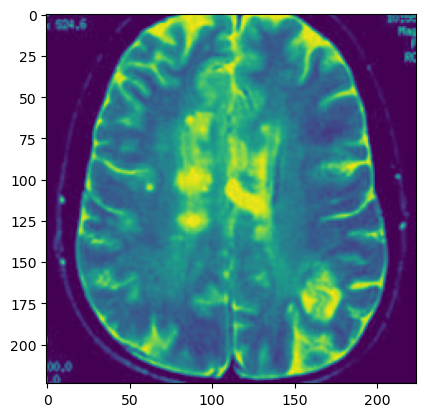

tensor([1., 0.], device='cuda:0')


In [15]:
_, random_label, random_sample = train_mem_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0).to("cpu"))
plt.show()
print(random_label)

In [16]:
mlp_hidden = 384 * 3
hidden = 384
num_layers = 7
head = 12

batch_size_train_cls = 4
batch_size_train_mem = 4
batch_size_test = 4

In [17]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = batch_size_train_cls,
                              shuffle = True)

test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size_test,
                             shuffle = True)

train_mem_dataloader = DataLoader(train_mem_dataset, 
                                  batch_size = batch_size_train_mem, 
                                  shuffle=False)

In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, feats: int, mlp_hidden: int, head: int = 8, dropout: float = 0.):
        super(TransformerEncoder, self).__init__()
        self.la1 = nn.LayerNorm(feats)
        self.msa = MultiHeadSelfAttention(feats, head=head, dropout=dropout)
        self.la2 = nn.LayerNorm(feats)
        self.mlp = nn.Sequential(
            nn.Linear(feats, mlp_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, feats),
            nn.GELU(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        out = self.msa(self.la1(x)) + x
        out = self.mlp(self.la2(out)) + out
        return out


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, feats: int, head: int = 8, dropout: float = 0.):
        super(MultiHeadSelfAttention, self).__init__()
        self.head = head
        self.feats = feats
        self.sqrt_d = self.feats ** 0.5

        self.q = nn.Linear(feats, feats)
        self.k = nn.Linear(feats, feats)
        self.v = nn.Linear(feats, feats)

        self.o = nn.Linear(feats, feats)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, n, f = x.size()
        q = self.q(x).view(b, n, self.head, self.feats // self.head).transpose(1, 2)
        k = self.k(x).view(b, n, self.head, self.feats // self.head).transpose(1, 2)
        v = self.v(x).view(b, n, self.head, self.feats // self.head).transpose(1, 2)

        score = F.softmax(torch.einsum("bhif, bhjf->bhij", q, k) / self.sqrt_d, dim=-1)  # (b,h,n,n)
        attn = torch.einsum("bhij, bhjf->bihf", score, v)  # (b,n,h,f//h)
        o = self.dropout(self.o(attn.flatten(2)))
        return o


class ViT(nn.Module):
    def __init__(self, in_c: int = 1, num_classes: int = 10, img_size: int = 224, patch: int = 16,
                 dropout: float = 0., num_layers: int = 7, hidden: int = 416,
                 mlp_hidden: int = 416 * 4, head: int = 8):
        super(ViT, self).__init__()

        self.hidden = hidden
        self.patch = patch  # number of patches in one row(or col)
        self.patch_size = img_size // self.patch
        f = (img_size // self.patch) ** 2 * in_c  # patch vector length
        self.num_tokens = self.patch ** 2

        self.emb = nn.Linear(f, hidden)  # (b, n, f)
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_tokens, hidden))
        enc_list = [TransformerEncoder(hidden, mlp_hidden=mlp_hidden, dropout=dropout, head=head) for _ in range(num_layers)]

        enc_list_reversed = enc_list[-1::]

        self.enc = nn.Sequential(*enc_list)
        self.enc_reversed = nn.Sequential(*enc_list_reversed)

        self.fc = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_classes)  # for cls_token
        )

    def forward(self, x):
        out = self._to_words(x)
        out = self.emb(out)
        out = out + self.pos_emb
        out = self.enc(out)
        out = out.mean(1)
        out = self.fc(out)
        return out

    def forward_transposed(self, code):
        code = torch.matmul(code, self.fc[1].weight)
        code = self.fc[0](code)
        code = code.reshape(code.size(0), 1, self.hidden) + self.pos_emb

        code = self.enc_reversed(code)
        code = torch.matmul(code, self.emb.weight)
        img = self._from_words(code)
        return img

    def _to_words(self, x):
        """
        (b, c, h, w) -> (b, n, f)
        """
        out = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).permute(0, 2, 3, 4, 5, 1)
        out = out.reshape(x.size(0), self.patch ** 2, -1)
        return out

    def _from_words(self, x):
        """
        (b, n, f) -> (b, c, h, w)
        """
        x = x.reshape(x.size(0), self.patch ** 2, 1, self.patch_size, self.patch_size)
        b, p, c, ph, pw = x.shape
        sh, sw = self.patch, self.patch
        x = x.view(b, sh, sw, c, ph, pw)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(b, c, self.patch * ph, self.patch * pw)
        return x

In [19]:
input_size = int(1*224*224)
output_size = int(num_classes)

In [20]:
model = ViT(in_c=1, 
            num_classes=num_classes, 
            img_size=224,
            patch=16,
            hidden=hidden, 
            mlp_hidden=mlp_hidden, 
            num_layers=num_layers, 
            head=head).to(device)

In [21]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [22]:
# Adjust the number of training iterations and optimization settings to your likeings

CE = LabelSmoothingCrossEntropyLoss(classes=10, smoothing=0.2)
MSE = nn.MSELoss()
best_loss_r = np.inf
iterations=1500

optimizer_cls = optim.AdamW(model.parameters(), lr=1e-4,)

lr_scheduler_cls = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cls,
                                                          T_max=iterations, 
                                                              eta_min=1e-6)
scheduler_cls = warmup_scheduler.GradualWarmupScheduler(optimizer_cls, multiplier=1.,
                                                    total_epoch=5, after_scheduler=lr_scheduler_cls)


optimizer_mem = optim.AdamW(model.parameters(), lr=1e-3,)
lr_scheduler_mem = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_mem,
                                                          T_max=iterations,
                                                              eta_min=1e-5)
scheduler_mem = warmup_scheduler.GradualWarmupScheduler(optimizer_mem, multiplier=1.,
                                                    total_epoch=5, after_scheduler=lr_scheduler_mem)

In [23]:
save_path = f'./models/brain_vit_{hidden}width_{mlp_hidden}mlp_dim_{num_layers}layers_train_batch_{batch_size_train_cls}_p_{percentage}_chunk_{chunk_index}.pt'
save_path

'./models/brain_vit_384width_1152mlp_dim_7layers_train_batch_4_p_0.1_chunk_0.pt'

In [24]:
if not os.path.exists("./models"):
    os.makedirs("./models")

for epoch in range(iterations):
    loss_c = 0
    loss_r = 0
    loss = 0
    c=0
    for (code, _, imgs), (data, labels) in zip(train_mem_dataloader,
                                  train_dataloader):
        data = data.to(device)
        code = code.to(device)
        imgs = imgs.to(device)
        labels = labels.to(torch.int64)
        labels = labels.to(device)
        

        optimizer_cls.zero_grad()
        optimizer_mem.zero_grad()
        predlabel = model(data)
        loss_classf = CE(predlabel,
                         labels)
        loss_classf.backward()   
        optimizer_cls.step()
        
        optimizer_mem.zero_grad()
        optimizer_cls.zero_grad()
        predimg = model.forward_transposed(code)
        loss_recon = MSE(predimg, imgs)
        loss_recon.backward()
        optimizer_mem.step()

        loss_c += loss_classf.item()
        loss_r += loss_recon.item()
        c+=1
    
    scheduler_cls.step()
    scheduler_mem.step()
    print("Iteration : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, iterations, loss_c/c, loss_r/c))
    logging.info("Iteration : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, iterations, loss_c/c, loss_r/c))    

Iteration : 1/1500, loss_c = 0.606004, loss_r = 1.454692
Iteration : 2/1500, loss_c = 0.593157, loss_r = 1.162779
Iteration : 3/1500, loss_c = 0.565392, loss_r = 0.783128
Iteration : 4/1500, loss_c = 0.415661, loss_r = 0.724336
Iteration : 5/1500, loss_c = 0.344490, loss_r = 0.618421
Iteration : 6/1500, loss_c = 0.426207, loss_r = 0.506807
Iteration : 7/1500, loss_c = 0.433867, loss_r = 0.388577
Iteration : 8/1500, loss_c = 0.701986, loss_r = 0.279555
Iteration : 9/1500, loss_c = 0.569326, loss_r = 0.211037
Iteration : 10/1500, loss_c = 0.409031, loss_r = 0.164177
Iteration : 11/1500, loss_c = 0.469826, loss_r = 0.130668
Iteration : 12/1500, loss_c = 0.413733, loss_r = 0.107353
Iteration : 13/1500, loss_c = 0.515122, loss_r = 0.089074
Iteration : 14/1500, loss_c = 0.427870, loss_r = 0.075116
Iteration : 15/1500, loss_c = 0.496647, loss_r = 0.066457
Iteration : 16/1500, loss_c = 0.585975, loss_r = 0.060812
Iteration : 17/1500, loss_c = 0.393310, loss_r = 0.055228
Iteration : 18/1500, lo

In [25]:
correct=0
total = 0
model.eval()
with torch.no_grad():
    for (inputs, labels) in test_dataloader:
        code = torch.zeros(inputs.size(0), 10, device=device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        ypred = output.max(dim=1, keepdim=True)[1].squeeze(1)
        correct += ypred.eq(labels).sum()
        total += ypred.size(0)
print("Acc", correct/total)

Acc tensor(0.8627, device='cuda:0')


tensor([4., 0.], device='cuda:0')


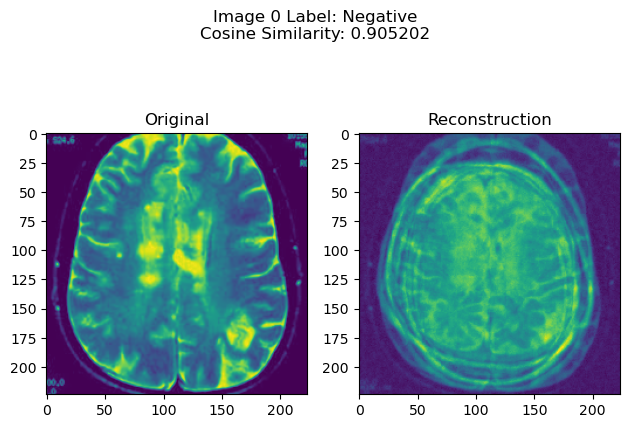

tensor([5., 0.], device='cuda:0')


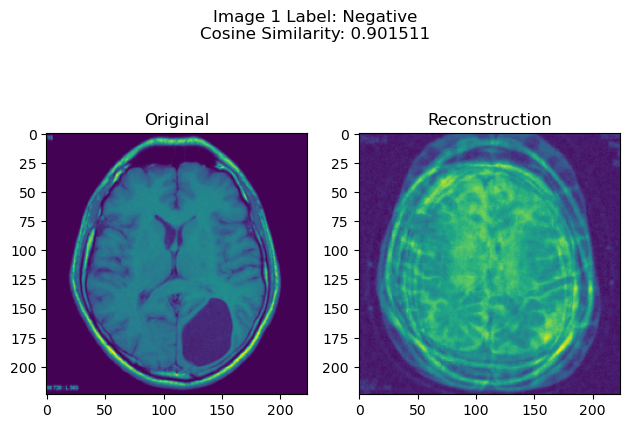

tensor([5., 1.], device='cuda:0')


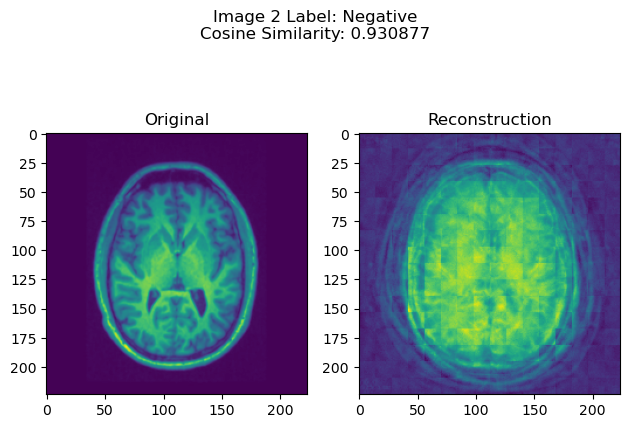

tensor([1., 3.], device='cuda:0')


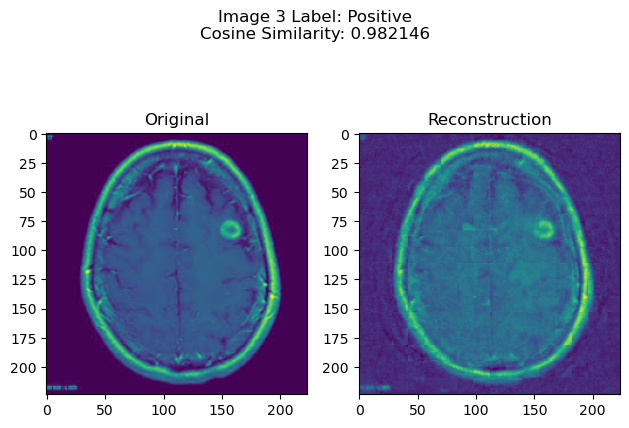

tensor([3., 1.], device='cuda:0')


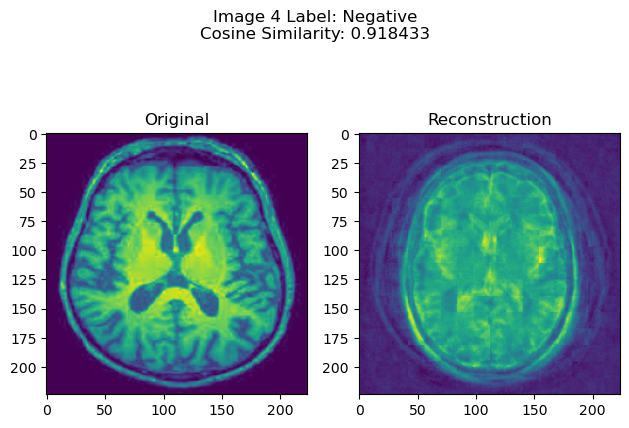

tensor([4., 1.], device='cuda:0')


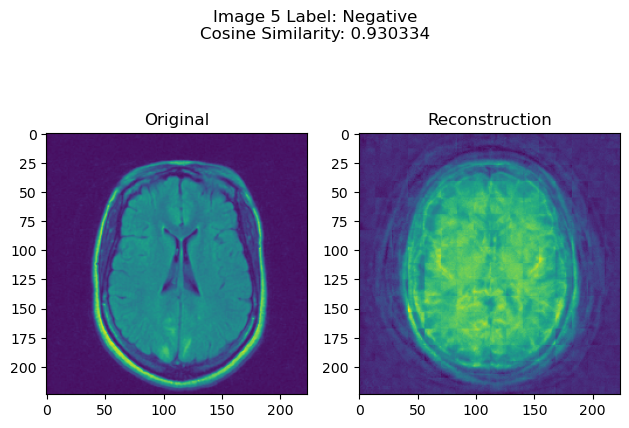

tensor([4., 2.], device='cuda:0')


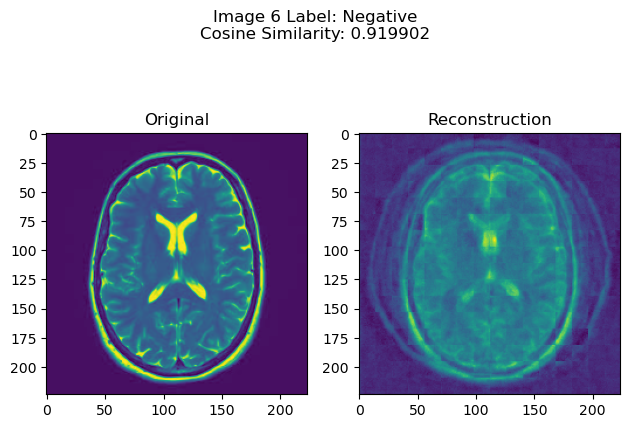

tensor([5., 2.], device='cuda:0')


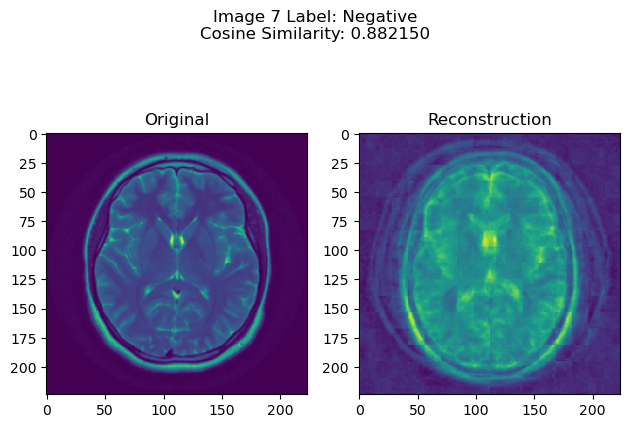

tensor([2., 3.], device='cuda:0')


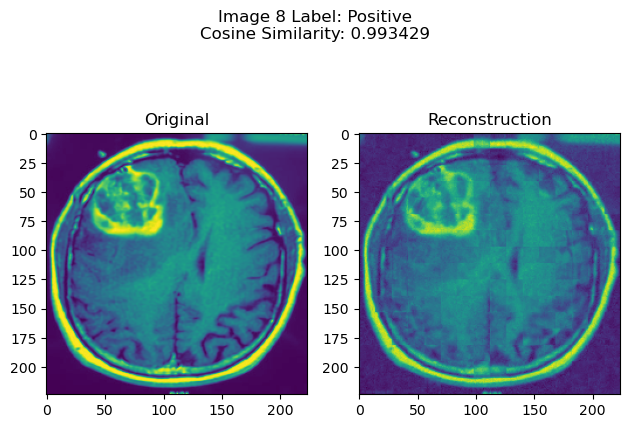

tensor([3., 2.], device='cuda:0')


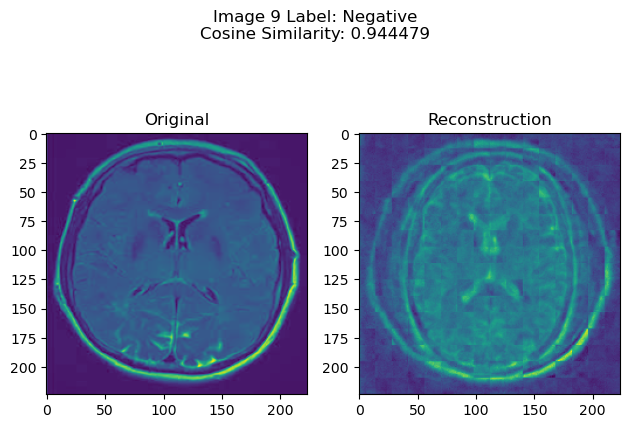

tensor([3., 0.], device='cuda:0')


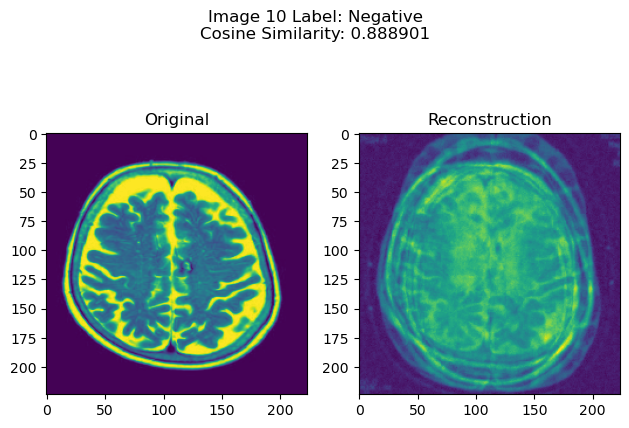

tensor([4., 0.], device='cuda:0')


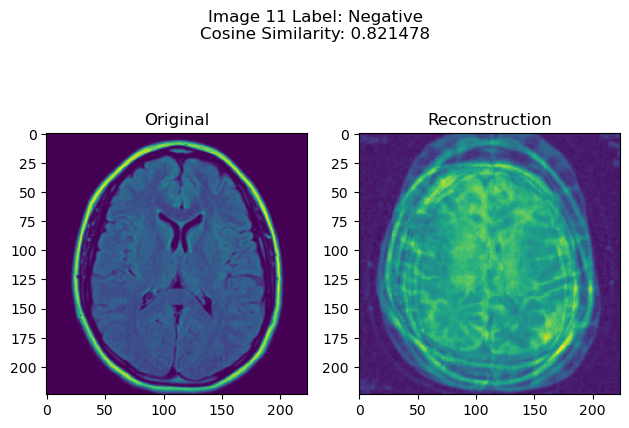

tensor([5., 0.], device='cuda:0')


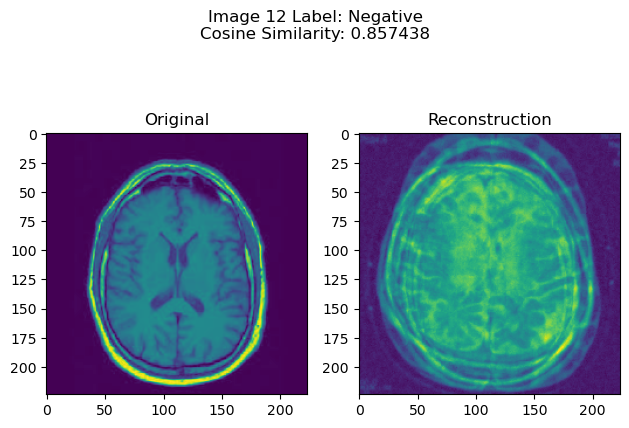

tensor([2., 4.], device='cuda:0')


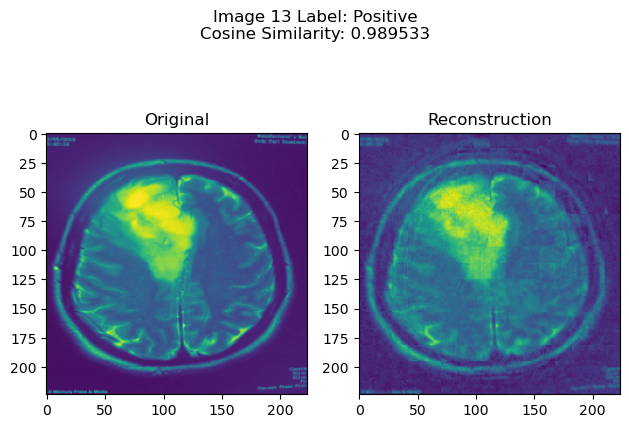

tensor([0., 4.], device='cuda:0')


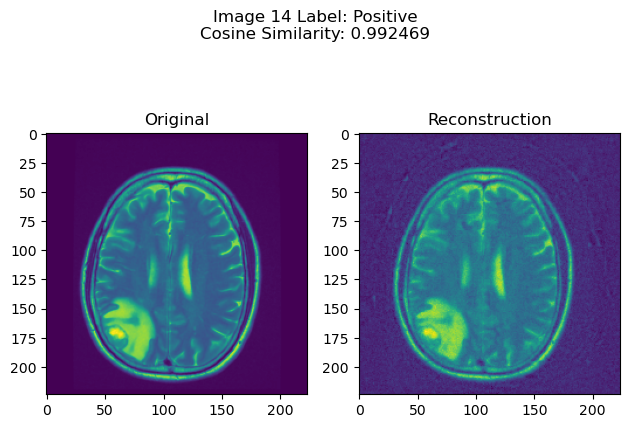

tensor([1., 4.], device='cuda:0')


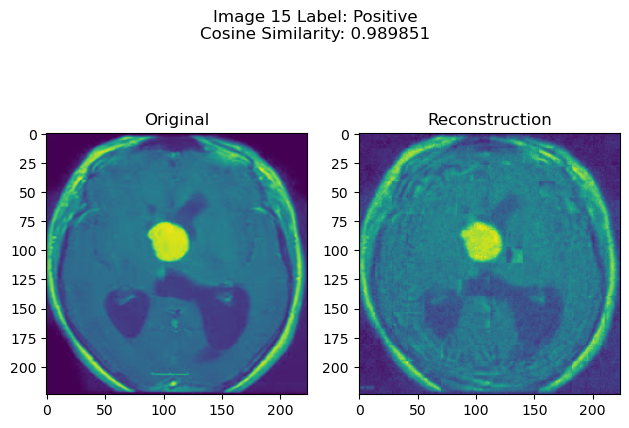

tensor([1., 5.], device='cuda:0')


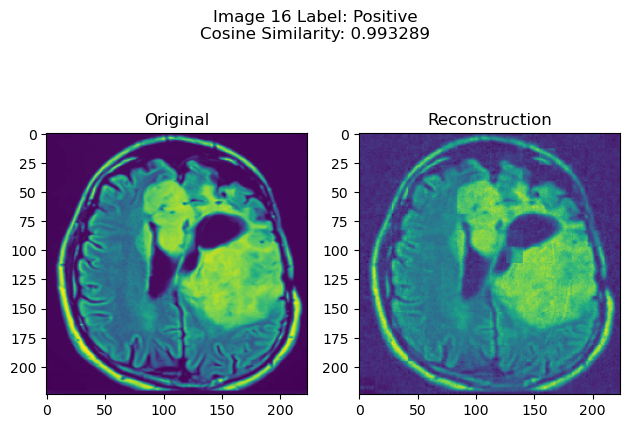

tensor([2., 5.], device='cuda:0')


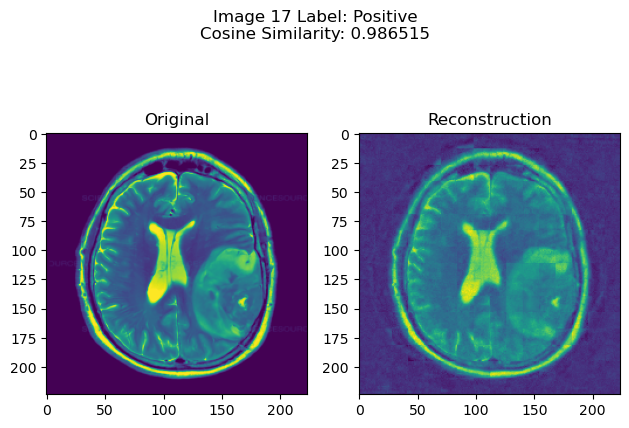

tensor([5., 1.], device='cuda:0')


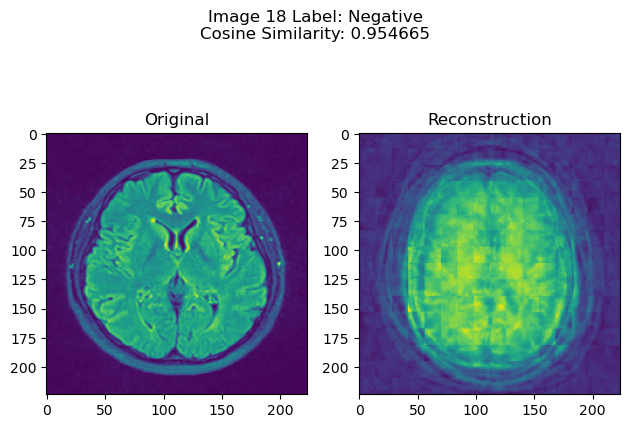

tensor([3., 1.], device='cuda:0')


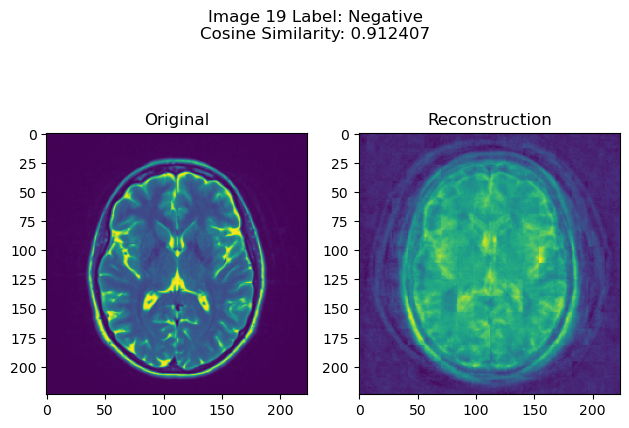

In [28]:
model.eval()
for idx, (code, label, img) in enumerate(train_mem_dataset):
    with torch.no_grad():
        rec_image = model.forward_transposed(code.view(1, -1))
        rec_image = rec_image.view(-1, 224, 224)
        rec_image = rec_image.to("cpu")
        img = img.to("cpu")
        label = torch.argmax(label)
        label = "Negative" if label == 0 else "Positive"
        # ssim_metric = ssim(img.squeeze().numpy(), rec_image.squeeze().numpy(), multichannel=False, data_range=1.0)
        cos0 = nn.CosineSimilarity(dim=0)
        cosine_similarity = cos0(img.view(-1), rec_image.view(-1))

        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        ax[0].imshow(img.permute(1, 2, 0))
        ax[0].set_title('Original')
        ax[1].imshow(rec_image.permute(1, 2, 0))
        ax[1].set_title("Reconstruction")
        plt.suptitle("Image {} Label: {}\nCosine Similarity: {:2f}".format(idx, label, cosine_similarity))
        print(code)
        plt.show()